In [1]:
from collections import defaultdict

import pandas as pd
from tqdm import tqdm
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Scaffolds.MurckoScaffold import GetScaffoldForMol
from rdkit.DataStructs.cDataStructs import BulkTanimotoSimilarity

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
ccsbase = pd.read_parquet(
    "ccs-prediction/ccs_base_experimental_clean.parquet"
)

metlin = pd.read_parquet(
    "ccs-prediction/metlin-clean-all-columns.parquet"
)

In [3]:
ccsbase_smiles = ccsbase["smiles"].unique()
metlin_smiles = metlin["smiles"].unique()

del ccsbase, metlin

In [4]:
def get_max_tanimoto_coefficient(smiles_list):

    # Calculate the max Tanimoto similarity for each molecule in the dataset
    mols = [Chem.MolFromSmiles(smi) for smi in smiles_list]

    # Fingerprints
    fps = []
    skipped = []

    for i, mol in enumerate(mols):

        if mol is None:
            skipped.append(i)
            continue
        try:
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
            fps.append((mol, fp))
        except:
            raise ValueError(f"Could not generate fingerprint for {mol}")

    print(f"Skipped {len(skipped)} molecules")

    murckos_list = []
    same_murckos = defaultdict(list)

    # Calculate Murcko scaffold for each molecule and group them
    for i, (mol, fp) in enumerate(fps):
        scaffold = Chem.MolToSmiles(GetScaffoldForMol(mol))

        same_murckos[scaffold].append(i)
        murckos_list.append(scaffold)

    fps = [fp for _, fp in fps]

    max_sim = []

    for i, fing1 in tqdm(enumerate(fps), total=len(fps)):
        tmp_fps = fps.copy()
        tmp_fps.pop(i)

        tanimoto = BulkTanimotoSimilarity(fing1, tmp_fps, returnDistance=False)

        max_sim.append(max(tanimoto))

    # Removing molecules with the same Murcko scaffold
    max_sim_with_murcko_filtering = []

    for i, fing1 in tqdm(enumerate(fps), total=len(fps)):
        # Fingerprints of molecules with different Murcko scaffolds
        tmp_fps = [
            fp for idx, fp in enumerate(fps) if idx not in same_murckos[murckos_list[i]]
        ]

        tanimoto = BulkTanimotoSimilarity(fing1, tmp_fps, returnDistance=False)

        max_sim_with_murcko_filtering.append(max(tanimoto))

    return max_sim, max_sim_with_murcko_filtering

In [5]:
tanimotos_metlin, tanimotos_metlin_with_murcko_filter = get_max_tanimoto_coefficient(
    metlin_smiles
)

tanimotos_ccsbase, tanimotos_ccsbase_with_murcko_filter = get_max_tanimoto_coefficient(
    ccsbase_smiles
)

[14:46:33] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[14:46:34] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 16 17 18
[14:46:35] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 14 15 16


Skipped 3 molecules


100%|██████████| 27629/27629 [04:38<00:00, 99.34it/s] 


Skipped 0 molecules


100%|██████████| 6075/6075 [02:01<00:00, 50.04it/s] 


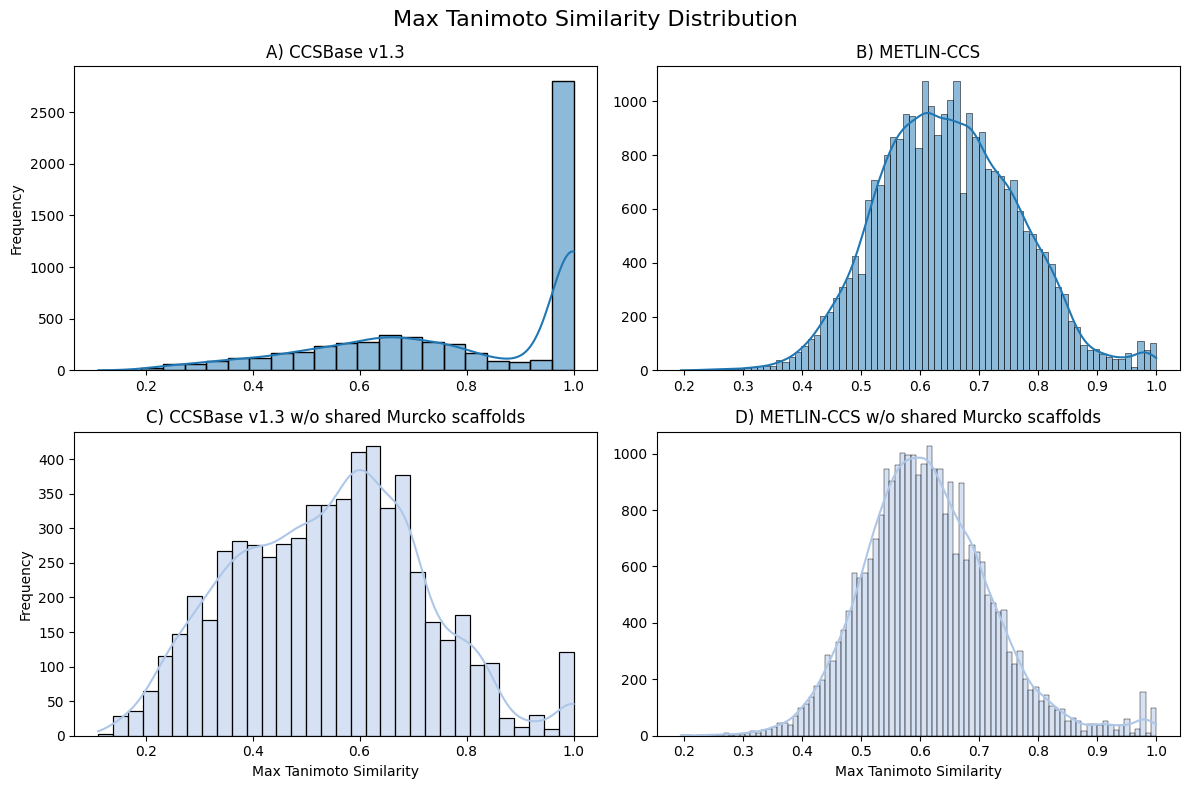

In [8]:
# Plot the distribution of Tanimoto similarity for both datasets side by side 2x2
plt.figure(figsize=(12, 8))

# first plot
plt.subplot(2, 2, 1)

sns.histplot(tanimotos_ccsbase, kde=True, color="#1f77b4")

plt.xlabel("")
plt.ylabel("Frequency")
plt.title("A) CCSBase v1.3")

# second plot
plt.subplot(2, 2, 2)

sns.histplot(tanimotos_metlin, kde=True, color="#1f77b4")

plt.xlabel("")
plt.ylabel("")
# title
plt.title("B) METLIN-CCS")

# third plot
plt.subplot(2, 2, 3)

sns.histplot(tanimotos_ccsbase_with_murcko_filter, kde=True, color="#aec7e8")

plt.xlabel("Max Tanimoto Similarity")
plt.ylabel("Frequency")
plt.title("C) CCSBase v1.3 w/o shared Murcko scaffolds")

# fourth plot
plt.subplot(2, 2, 4)

sns.histplot(tanimotos_metlin_with_murcko_filter, kde=True, color="#aec7e8")

# title
plt.title("D) METLIN-CCS w/o shared Murcko scaffolds")
plt.xlabel("Max Tanimoto Similarity")
plt.ylabel("")

# Super title
plt.suptitle("Max Tanimoto Similarity Distribution", fontsize=16)

plt.tight_layout()

# Save the plot
plt.savefig("max_tanimoto_similarity_distribution.png", dpi=500)

plt.show()